## Loosely based on Chapter 6 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python)

In [16]:
import keras, os
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Dropout
%matplotlib inline

model_dir = 'models'

In [2]:
data_folder = 'aclImdb'
train_dir = os.path.join(data_folder, 'train')

labels = []
texts = []

def parse_txt_file(fname):
    with open(fname, 'r') as f:
        return f.read()

def parse_folder(folder):
    texts = []
    for fname in os.listdir(folder):
        if fname.endswith('.txt'):
            texts.append(parse_txt_file(os.path.join(folder, fname)))
    return texts

def parse_data(directory): 
    neg_texts = parse_folder(os.path.join(directory, 'neg'))
    pos_texts = parse_folder(os.path.join(directory, 'pos'))
    labels = [0] * len(neg_texts)
    labels.extend([1] * len(pos_texts))
    return neg_texts + pos_texts, labels

texts, labels = parse_data(train_dir)

In [3]:
texts_train, texts_val, y_train, y_val = train_test_split(texts, labels, test_size=0.20, shuffle=True, random_state=42)

In [5]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

maxlen = 100
training_samples = 1000
max_words = 10000

tokenizer = Tokenizer(num_words=max_words)

tokenizer.fit_on_texts(texts_train)
x_train = pad_sequences(tokenizer.texts_to_sequences(texts_train), maxlen=maxlen)
x_val = pad_sequences(tokenizer.texts_to_sequences(texts_val), maxlen=maxlen)

In [6]:
word_index = tokenizer.word_index
print('Found {} unique word tokens'.format(len(word_index)))

Found 80080 unique word tokens


### Model with word embedding and a small DNN classifier

In [7]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

embedding_dim = 100

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [8]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_val, y_val))
model.save(os.path.join(model_dir, 'imdb-embedding.h5'))

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 5s 234us/step - loss: 0.4286 - acc: 0.7938 - val_loss: 0.3525 - val_acc: 0.8476
Epoch 2/10
20000/20000 [==============================] - 4s 201us/step - loss: 0.1366 - acc: 0.9506 - val_loss: 0.4528 - val_acc: 0.8226
Epoch 3/10
20000/20000 [==============================] - 4s 202us/step - loss: 0.0145 - acc: 0.9961 - val_loss: 0.7397 - val_acc: 0.8054
Epoch 4/10
20000/20000 [==============================] - 4s 201us/step - loss: 5.9039e-04 - acc: 0.9999 - val_loss: 0.9432 - val_acc: 0.8206
Epoch 5/10
20000/20000 [==============================] - 4s 203us/step - loss: 5.8525e-06 - acc: 1.0000 - val_loss: 1.1361 - val_acc: 0.8166
Epoch 6/10
20000/20000 [==============================] - 4s 201us/step - loss: 1.6082e-07 - acc: 1.0000 - val_loss: 1.2046 - val_acc: 0.8222
Epoch 7/10
20000/20000 [==============================] - 4s 201us/step - loss: 1.1127e-07 - acc: 1.0000 - val_

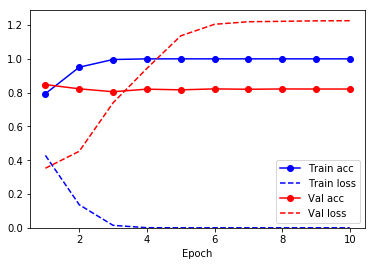

In [14]:
def print_history(history):
    acc = history.history['acc']
    loss = history.history['loss']
    val_acc = history.history['val_acc']
    val_loss = history.history['val_loss']
    
    epochs = range(1, len(acc) + 1)
    fig, ax = plt.subplots()
    ax.plot(epochs, acc, 'bo-', label='Train acc')
    ax.plot(epochs, loss, 'b--', label='Train loss')
    ax.plot(epochs, val_acc, 'ro-', label='Val acc')
    ax.plot(epochs, val_loss, 'r--', label='Val loss')
    ax.set(ylim=[0, None],
           xlabel='Epoch')
    ax.legend()
    
print_history(history)

Try Dropout to combat overfitting:

In [20]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Dropout(rate=0.20, noise_shape=(None, maxlen, 1), seed=42))
model.add(Flatten())
model.add(Dropout(rate=0.20), seed=42)
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
dropout_2 (Dropout)          (None, 100, 100)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 10000)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [21]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_val, y_val))
model.save(os.path.join(model_dir, 'imdb-embedding.h5'))

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 6s 280us/step - loss: 0.4746 - acc: 0.7596 - val_loss: 0.3645 - val_acc: 0.8374
Epoch 2/10
20000/20000 [==============================] - 5s 256us/step - loss: 0.2407 - acc: 0.9017 - val_loss: 0.3759 - val_acc: 0.8350
Epoch 3/10
20000/20000 [==============================] - 5s 262us/step - loss: 0.1076 - acc: 0.9597 - val_loss: 0.4680 - val_acc: 0.8258
Epoch 4/10
20000/20000 [==============================] - 5s 262us/step - loss: 0.0451 - acc: 0.9832 - val_loss: 0.5990 - val_acc: 0.8166
Epoch 5/10
20000/20000 [==============================] - 5s 259us/step - loss: 0.0242 - acc: 0.9911 - val_loss: 0.6915 - val_acc: 0.8160
Epoch 6/10
20000/20000 [==============================] - 5s 258us/step - loss: 0.0142 - acc: 0.9944 - val_loss: 0.7850 - val_acc: 0.8174
Epoch 7/10
20000/20000 [==============================] - 5s 259us/step - loss: 0.0116 - acc: 0.9960 - val_loss: 0.8547 - v

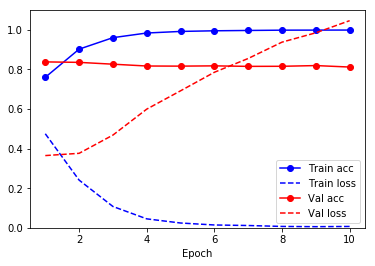

In [22]:
print_history(history)